In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from Utils import plot_roc_curve, report, plot_lost_history, _confusion_matrix

In [2]:
df_orginal = pd.read_csv("../Datasets/pulsar_stars.csv")

In [3]:
df_orginal.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [4]:
df_orginal.isnull().sum()

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

In [5]:
df_orginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                17898 non-null  float64
 1    Standard deviation of the integrated profile  17898 non-null  float64
 2    Excess kurtosis of the integrated profile     17898 non-null  float64
 3    Skewness of the integrated profile            17898 non-null  float64
 4    Mean of the DM-SNR curve                      17898 non-null  float64
 5    Standard deviation of the DM-SNR curve        17898 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7    Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                   17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


array([[<AxesSubplot:title={'center':' Mean of the integrated profile'}>,
        <AxesSubplot:title={'center':' Standard deviation of the integrated profile'}>,
        <AxesSubplot:title={'center':' Excess kurtosis of the integrated profile'}>],
       [<AxesSubplot:title={'center':' Skewness of the integrated profile'}>,
        <AxesSubplot:title={'center':' Mean of the DM-SNR curve'}>,
        <AxesSubplot:title={'center':' Standard deviation of the DM-SNR curve'}>],
       [<AxesSubplot:title={'center':' Excess kurtosis of the DM-SNR curve'}>,
        <AxesSubplot:title={'center':' Skewness of the DM-SNR curve'}>,
        <AxesSubplot:title={'center':'target_class'}>]], dtype=object)

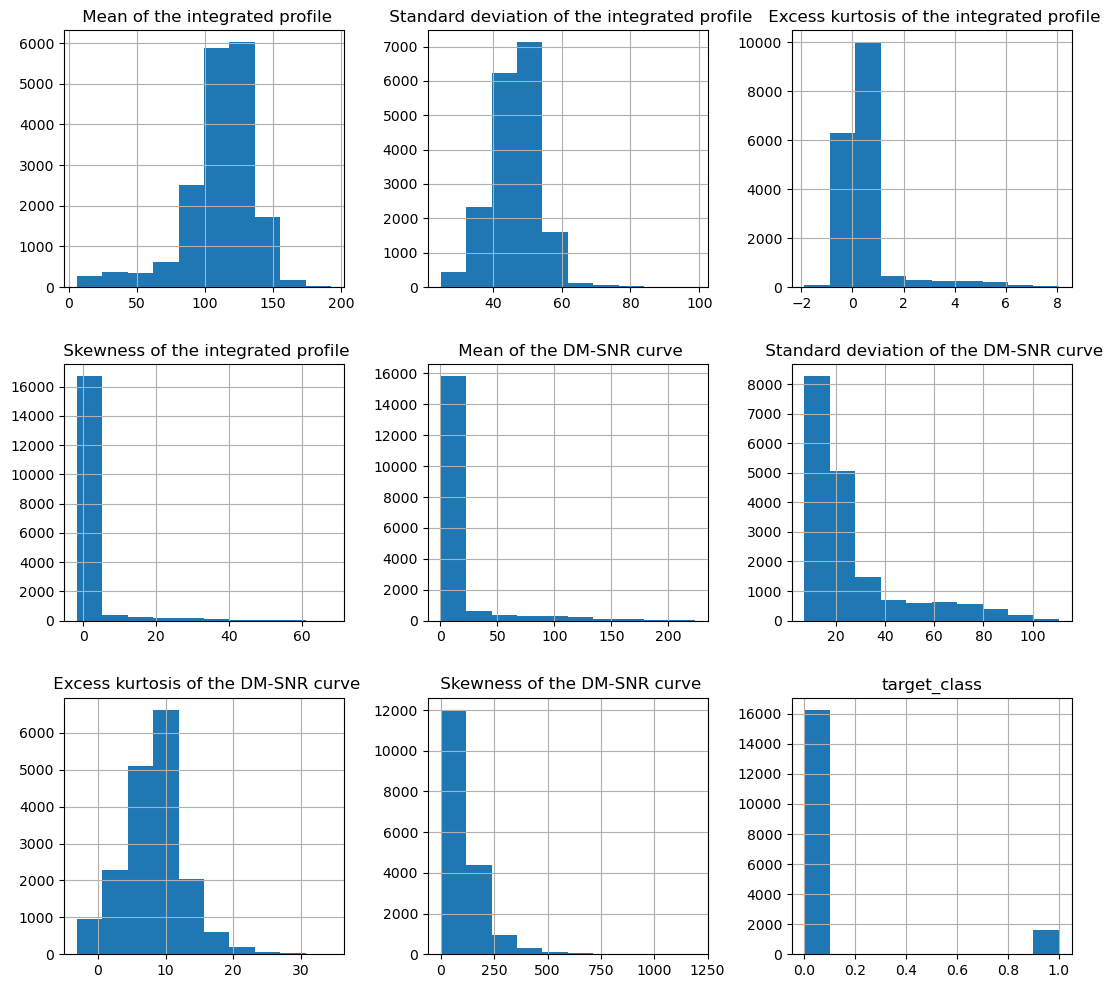

In [6]:
df_orginal.hist(figsize=(13, 12))

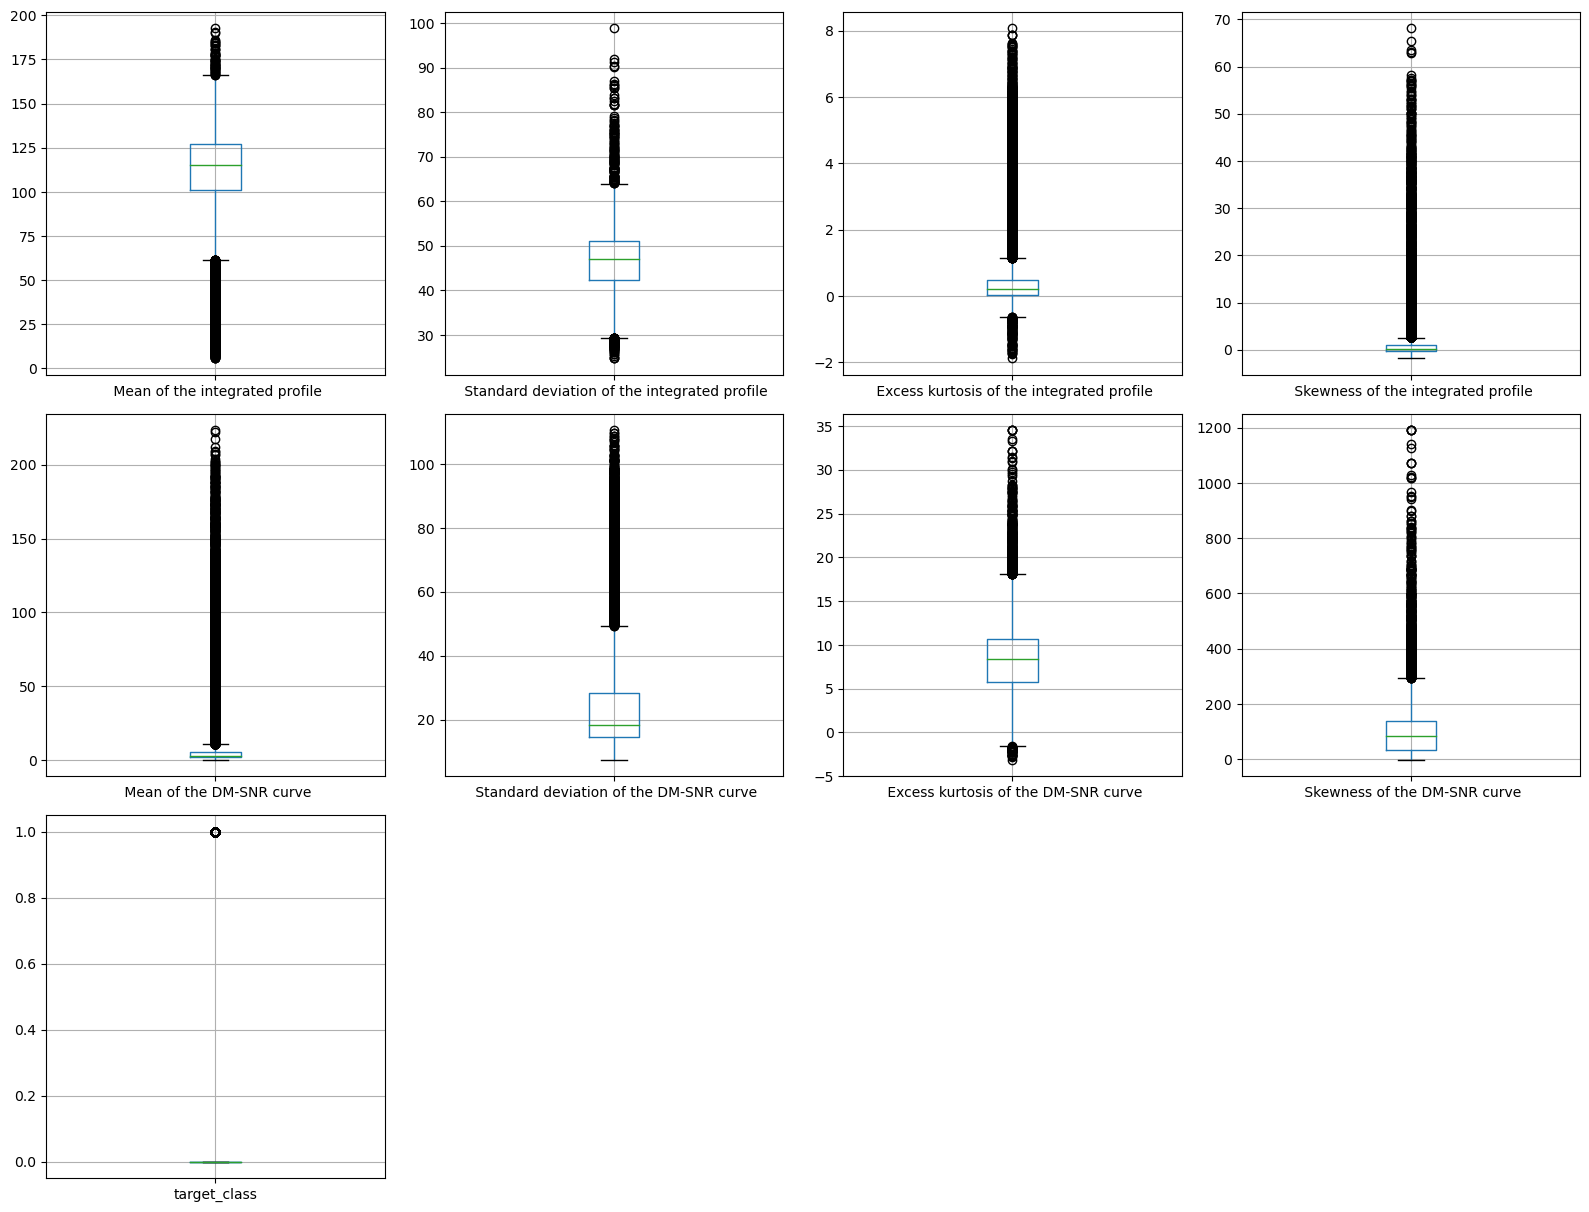

In [7]:
plt.figure(figsize=(16 , 16))
for i, col in enumerate(df_orginal.columns):
    plt.subplot(4, 4, i + 1)
    df_orginal.boxplot(col)
    plt.tight_layout()

In [8]:
df_orginal.target_class.value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

In [9]:
new_df = df_orginal.copy()

new_df.columns = new_df.columns.str.lower()
new_df.columns = new_df.columns.str.strip()
new_df.columns = new_df.columns.str.replace(" ", "_")
new_df.columns = new_df.columns.str.replace("-", "_")

<AxesSubplot:>

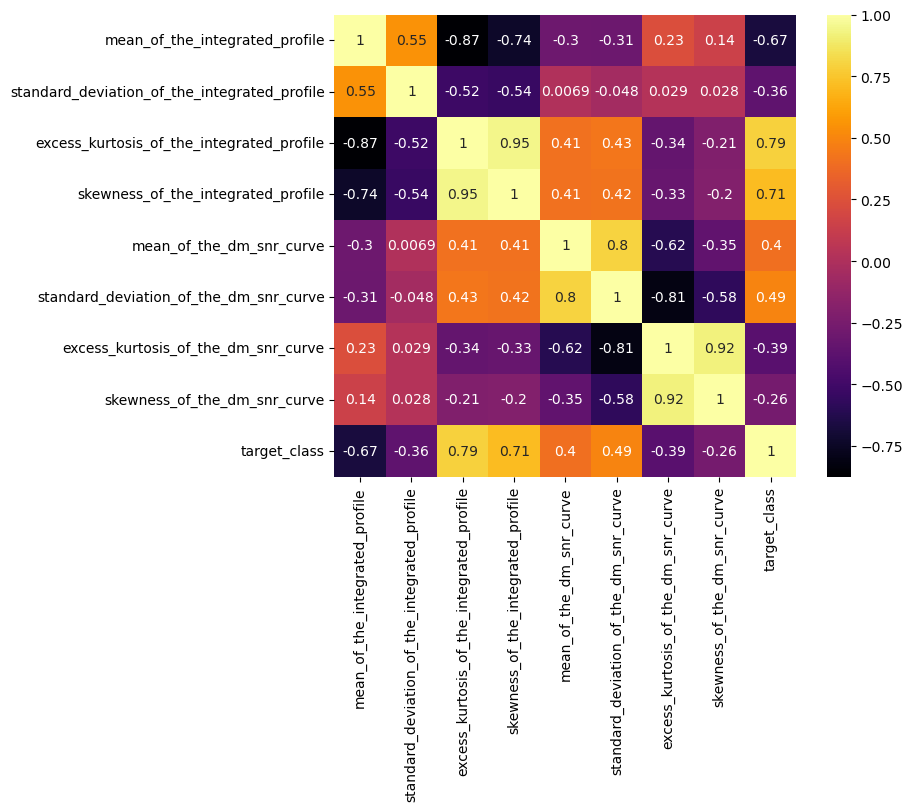

In [10]:
corr = new_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, vmax=1, square=True,annot=True,cmap='inferno')

In [11]:
# !pip install imblearn

/opt/anaconda3/envs/CustomEnvironments/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


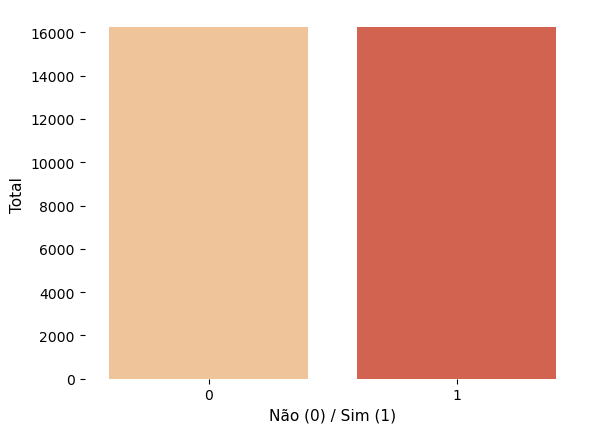

In [12]:
import imblearn
from imblearn.over_sampling import SMOTE

seed = 10

columns = ["mean_of_the_integrated_profile", "excess_kurtosis_of_the_integrated_profile", "skewness_of_the_integrated_profile", "mean_of_the_dm_snr_curve", "excess_kurtosis_of_the_dm_snr_curve"]

X = new_df[columns]
y = new_df["target_class"]

smote_bal = SMOTE(random_state = seed)

X_res, y_res = smote_bal.fit_resample(X, y)

X = X_res
y = y_res

sns.countplot(y_res, palette='OrRd')
plt.box(False)
plt.xlabel("Não (0) / Sim (1)", fontsize=11)
plt.ylabel("Total", fontsize=11)
plt.show()

In [13]:
min_max_scaler = MinMaxScaler()
X_min_max_scaled = min_max_scaler.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_min_max_scaled, y, test_size=0.20, random_state=42)

In [15]:
def evaluate_model_accuracy_loss(model, X_test, y_test):
    test_results = model.evaluate(X_test, y_test, verbose=1)
    print('Test results - Loss: {0} - Accuracy: {1}'.format(test_results[0], test_results[1] * 100))

In [16]:
def append_binary_results(y_test):
    results = []
    for i in range(len(y_test)):
        if y_test[i] >= 0.55:
            results.append(1)
        else:
            results.append(0)
    
    return results

In [17]:
tf.random.set_seed(42)

In [18]:
X.shape

(32518, 5)

Epoch 1/100


2022-10-19 00:08:11.530845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/CustomEnvironments/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


813/813 [==============================] - 1s 958us/step - loss: 0.3721 - accuracy: 0.8817 - val_loss: 0.2212 - val_accuracy: 0.9267
Epoch 2/100
813/813 [==============================] - 1s 1ms/step - loss: 0.2071 - accuracy: 0.9283 - val_loss: 0.1980 - val_accuracy: 0.9323
Epoch 3/100
813/813 [==============================] - 1s 753us/step - loss: 0.1967 - accuracy: 0.9291 - val_loss: 0.1936 - val_accuracy: 0.9319
Epoch 4/100
813/813 [==============================] - 1s 747us/step - loss: 0.1946 - accuracy: 0.9291 - val_loss: 0.1930 - val_accuracy: 0.9325
Epoch 5/100
813/813 [==============================] - 1s 873us/step - loss: 0.1936 - accuracy: 0.9295 - val_loss: 0.1913 - val_accuracy: 0.9328
Epoch 6/100
813/813 [==============================] - 1s 768us/step - loss: 0.1925 - accuracy: 0.9305 - val_loss: 0.1902 - val_accuracy: 0.9333
Epoch 7/100
813/813 [==============================] - 1s 771us/step - loss: 0.1911 - accuracy: 0.9316 - val_loss: 0.1909 - val_accuracy: 0.9334

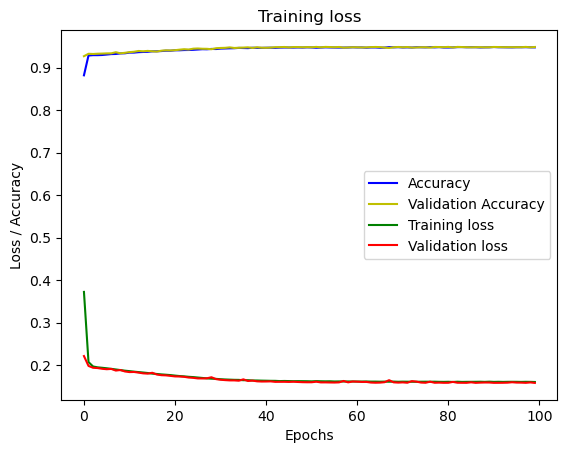

Epoch 1/100
813/813 [==============================] - 1s 893us/step - loss: 0.4415 - accuracy: 0.8669 - val_loss: 0.2883 - val_accuracy: 0.9205
Epoch 2/100
813/813 [==============================] - 1s 777us/step - loss: 0.2353 - accuracy: 0.9233 - val_loss: 0.2166 - val_accuracy: 0.9296
Epoch 3/100
813/813 [==============================] - 1s 773us/step - loss: 0.2147 - accuracy: 0.9287 - val_loss: 0.2108 - val_accuracy: 0.9316
Epoch 4/100
813/813 [==============================] - 1s 783us/step - loss: 0.2113 - accuracy: 0.9288 - val_loss: 0.2094 - val_accuracy: 0.9313
Epoch 5/100
813/813 [==============================] - 1s 771us/step - loss: 0.2094 - accuracy: 0.9298 - val_loss: 0.2067 - val_accuracy: 0.9339
Epoch 6/100
813/813 [==============================] - 1s 783us/step - loss: 0.2076 - accuracy: 0.9313 - val_loss: 0.2053 - val_accuracy: 0.9342
Epoch 7/100
813/813 [==============================] - 1s 773us/step - loss: 0.2059 - accuracy: 0.9315 - val_loss: 0.2063 - val_ac

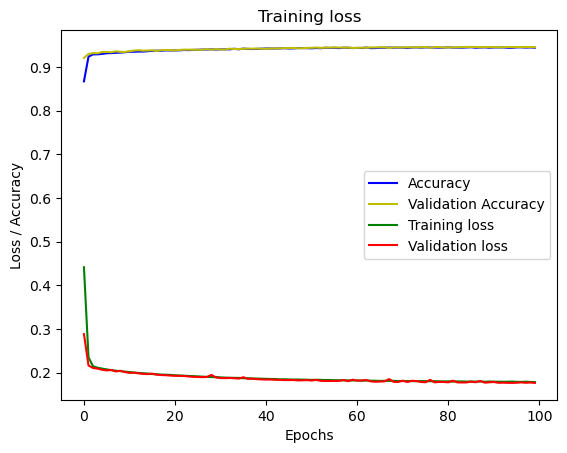

Epoch 1/100
813/813 [==============================] - 1s 872us/step - loss: 0.5341 - accuracy: 0.8447 - val_loss: 0.3569 - val_accuracy: 0.9111
Epoch 2/100
813/813 [==============================] - 1s 748us/step - loss: 0.3273 - accuracy: 0.9162 - val_loss: 0.3056 - val_accuracy: 0.9253
Epoch 3/100
813/813 [==============================] - 1s 749us/step - loss: 0.2969 - accuracy: 0.9219 - val_loss: 0.2859 - val_accuracy: 0.9262
Epoch 4/100
813/813 [==============================] - 1s 751us/step - loss: 0.2835 - accuracy: 0.9239 - val_loss: 0.2778 - val_accuracy: 0.9279
Epoch 5/100
813/813 [==============================] - 1s 747us/step - loss: 0.2758 - accuracy: 0.9241 - val_loss: 0.2698 - val_accuracy: 0.9282
Epoch 6/100
813/813 [==============================] - 1s 749us/step - loss: 0.2700 - accuracy: 0.9250 - val_loss: 0.2651 - val_accuracy: 0.9274
Epoch 7/100
813/813 [==============================] - 1s 748us/step - loss: 0.2650 - accuracy: 0.9259 - val_loss: 0.2629 - val_ac

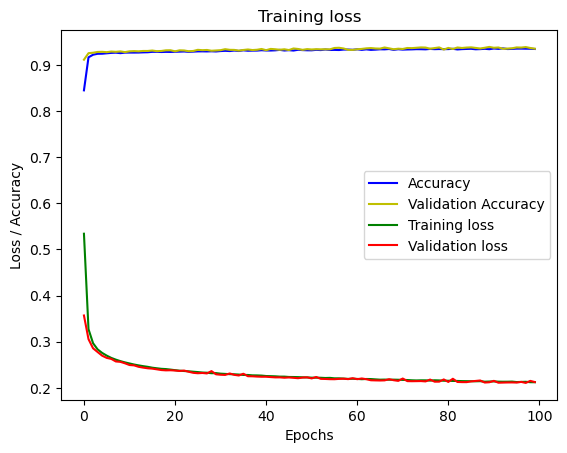

Epoch 1/100
813/813 [==============================] - 1s 877us/step - loss: 0.7547 - accuracy: 0.8819 - val_loss: 0.6043 - val_accuracy: 0.9250
Epoch 2/100
813/813 [==============================] - 1s 751us/step - loss: 0.5632 - accuracy: 0.9170 - val_loss: 0.5330 - val_accuracy: 0.9207
Epoch 3/100
813/813 [==============================] - 1s 751us/step - loss: 0.5109 - accuracy: 0.9107 - val_loss: 0.4900 - val_accuracy: 0.9156
Epoch 4/100
813/813 [==============================] - 1s 742us/step - loss: 0.4767 - accuracy: 0.9109 - val_loss: 0.4621 - val_accuracy: 0.9213
Epoch 5/100
813/813 [==============================] - 1s 748us/step - loss: 0.4517 - accuracy: 0.9117 - val_loss: 0.4385 - val_accuracy: 0.9191
Epoch 6/100
813/813 [==============================] - 1s 745us/step - loss: 0.4318 - accuracy: 0.9124 - val_loss: 0.4203 - val_accuracy: 0.9157
Epoch 7/100
813/813 [==============================] - 1s 741us/step - loss: 0.4153 - accuracy: 0.9132 - val_loss: 0.4074 - val_ac

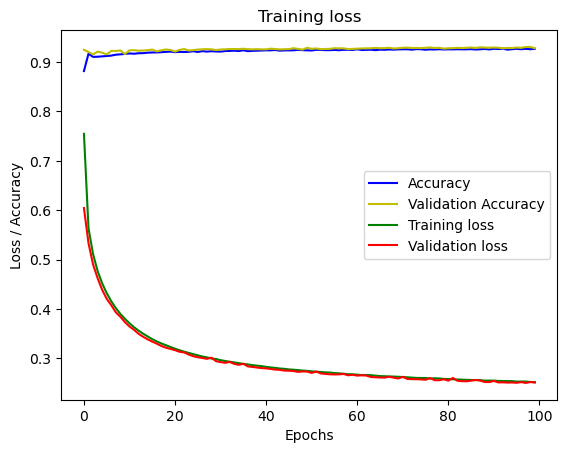

Epoch 1/100
813/813 [==============================] - 1s 905us/step - loss: 0.8868 - accuracy: 0.8782 - val_loss: 0.7043 - val_accuracy: 0.9170
Epoch 2/100
813/813 [==============================] - 1s 782us/step - loss: 0.6775 - accuracy: 0.8808 - val_loss: 0.6438 - val_accuracy: 0.9170
Epoch 3/100
813/813 [==============================] - 1s 777us/step - loss: 0.6031 - accuracy: 0.8914 - val_loss: 0.5703 - val_accuracy: 0.8965
Epoch 4/100
813/813 [==============================] - 1s 781us/step - loss: 0.5527 - accuracy: 0.8971 - val_loss: 0.5348 - val_accuracy: 0.9153
Epoch 5/100
813/813 [==============================] - 1s 792us/step - loss: 0.5221 - accuracy: 0.9016 - val_loss: 0.5068 - val_accuracy: 0.9114
Epoch 6/100
813/813 [==============================] - 1s 785us/step - loss: 0.4993 - accuracy: 0.9050 - val_loss: 0.4869 - val_accuracy: 0.9033
Epoch 7/100
813/813 [==============================] - 1s 786us/step - loss: 0.4810 - accuracy: 0.9060 - val_loss: 0.4719 - val_ac

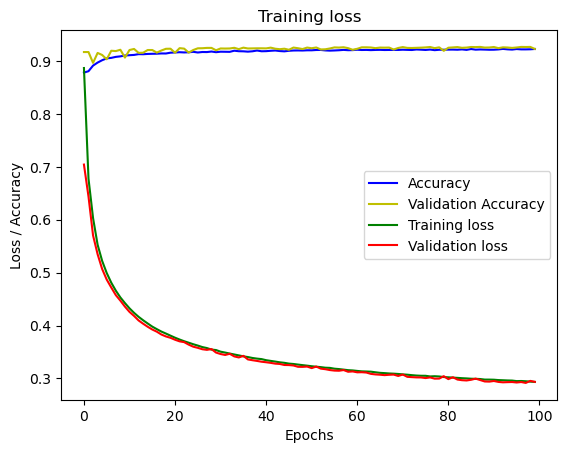

Epoch 1/100
813/813 [==============================] - 1s 913us/step - loss: 1.2301 - accuracy: 0.5316 - val_loss: 0.7534 - val_accuracy: 0.4905
Epoch 2/100
813/813 [==============================] - 1s 786us/step - loss: 0.7073 - accuracy: 0.5058 - val_loss: 0.6939 - val_accuracy: 0.4905
Epoch 3/100
813/813 [==============================] - 1s 785us/step - loss: 0.6933 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 4/100
813/813 [==============================] - 1s 785us/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 5/100
813/813 [==============================] - 1s 788us/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 6/100
813/813 [==============================] - 1s 784us/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 7/100
813/813 [==============================] - 1s 786us/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6933 - val_ac

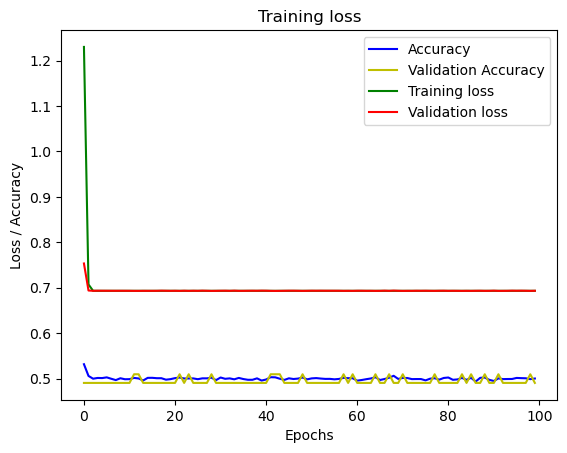

Epoch 1/100
813/813 [==============================] - 1s 911us/step - loss: 1.5944 - accuracy: 0.7668 - val_loss: 0.7717 - val_accuracy: 0.4905
Epoch 2/100
813/813 [==============================] - 1s 789us/step - loss: 0.7091 - accuracy: 0.5227 - val_loss: 0.6936 - val_accuracy: 0.4905
Epoch 3/100
813/813 [==============================] - 1s 783us/step - loss: 0.6933 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4905
Epoch 4/100
813/813 [==============================] - 1s 787us/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6935 - val_accuracy: 0.4905
Epoch 5/100
813/813 [==============================] - 1s 786us/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 6/100
813/813 [==============================] - 1s 788us/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6934 - val_accuracy: 0.4905
Epoch 7/100
813/813 [==============================] - 1s 784us/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6933 - val_ac

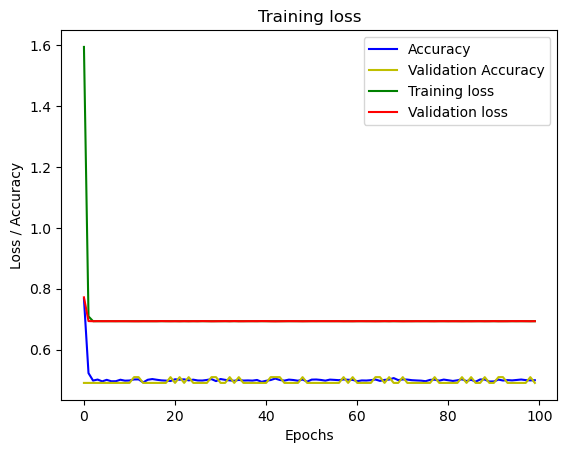

In [19]:
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(5, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(3, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(1, activation = 'sigmoid')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=['accuracy']
    )

    models[i].fit(
        X_train,y_train,
        epochs=100,
        validation_data=(X_test, y_test)
    )
    print("MODEL: {0}".format(i))
    plot_lost_history(models[i].history)

In [20]:
model = models[0]
y_hat = model.predict(X_test)

204/204 [==============================] - 0s 469us/step


In [21]:
predicted_class = append_binary_results(y_hat)

In [22]:
report(y_test, predicted_class)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3314
           1       0.98      0.92      0.95      3190

    accuracy                           0.95      6504
   macro avg       0.95      0.95      0.95      6504
weighted avg       0.95      0.95      0.95      6504



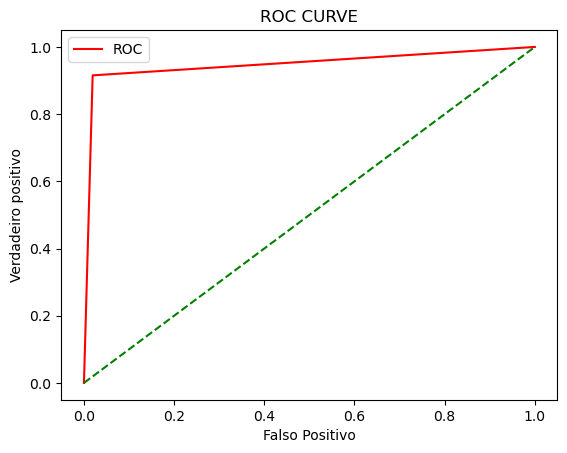

In [23]:
plot_roc_curve(y_test, predicted_class)